In [1]:
# Imports
import pathlib
from cv2 import imshow
from sklearn import datasets
import torch

import albumentations
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from skimage.transform import resize
from customdatasets import SegmentationDataSet1, SegmentationDataSet2, SegmentationDataSet3
from transformations import ComposeDouble, AlbuSeg2d, FunctionWrapperDouble, normalize_01, create_dense_target
from unet import UNet
from trainer import Trainer


# root directory
root = pathlib.Path.cwd()


def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
# inputs = get_filenames_of_path(root / 'dataset' / 'Input')
# targets = get_filenames_of_path(root / 'dataset' / 'target')

# inputs = get_filenames_of_path(root / 'Input')
# targets = get_filenames_of_path(root / 'Target')

inputs = get_filenames_of_path(root / 'TheYoung' / 'Input')
targets = get_filenames_of_path(root / 'TheYoung' / 'Target')

# inputs = get_filenames_of_path(root / 'Last_Dataset' / 'Input')
# targets = get_filenames_of_path(root / 'Last_Dataset' / 'Target')


# pre-transformations
pre_transforms = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(128, 128, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(128, 128),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
])


# training transformations and augmentations
transforms_training = ComposeDouble([
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet3(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataset validation
dataset_valid = SegmentationDataSet3(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)


# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dataloader=dataloader_training,
                  validation_dataloader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=10,
                  epoch=0,
                  notebook=True)

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]

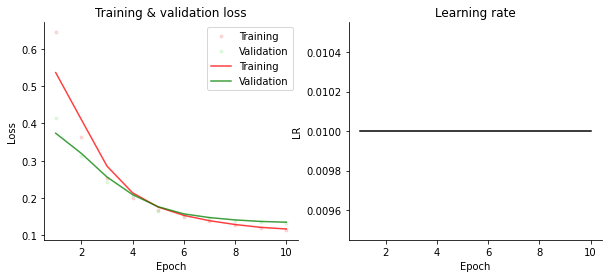

In [2]:
# start training

training_losses, validation_losses, lr_rates = trainer.run_trainer()

from visual import plot_training
fig = plot_training(training_losses,validation_losses,lr_rates,gaussian=True,sigma=1,figsize=(10,4))

In [ ]:
model_name = 'Last_Dataset_model.pt'
torch.save(model.state_dict(),pathlib.Path.cwd()/model_name)